In [68]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as signal
# from sklearn.cluster import KMeans
# import circle_fit as cf
from scipy import stats
import multiprocessing as mp
from torchvision import io
from torchvision import utils
# import cv2
from PIL import Image
import matplotlib.pyplot as plt
from queue import PriorityQueue



In [ ]:
data_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/'
out_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction-2bit/'
directories = os.listdir(data_dir)

In [ ]:
def uniform_quant(img):
	img = torch.where(img >= 0b10100000, 0b11000000, img)
	img = torch.where((img >= 0b01100000) & (img < 0b10100000), 0b10000000, img)
	img = torch.where((img >= 0b00100000) & (img < 0b01100000), 0b01000000, img)
	img = torch.where(img < 0b00100000, 0b00000000, img)
	return img

In [ ]:
def manual_quant(img):
	black_threshold = 42
	iris_threshold = 100
	skin_threshold = 210

	black_color = 0
	iris_color = 70
	skin_color = 160
	white_color = 255
	# first make the blacks 0
	img = torch.where(img < black_threshold, black_color, img)
	# make the iris color
	img = torch.where((img > black_threshold) & (img < iris_threshold), iris_color, img)
	# make the skin color
	img = torch.where((img > iris_threshold) & (img < skin_threshold), skin_color, img)
	# make the white color
	img = torch.where(img > skin_threshold, white_color, img)

In [ ]:
def peak_quant(img):
	hist = Counter(img.flatten().tolist())
	x = list(range(255))
	y = [hist[i] if i in hist else 0 for i in x]

	peak_x, peak_y = signal.find_peaks(y, height=100, distance=30)
	peak_y = peak_y['peak_heights']
	if len(peak_y) > 3:
		ind = np.argpartition(peak_y, -3)[-3:]
		top4 = peak_x[ind].tolist()
		top4.append(255)
	else:
		top4 = peak_x.tolist()
		top4.append(255)
	top4 = np.sort(top4)

	bin_centers = (top4[1:]+top4[:-1])/2
	img_q = np.digitize(img, bin_centers, right=False)
	img_q = np.where(img_q == min(top4), 0, img_q)
	return img_q
	# plt.figure()
	# plt.imshow(img_q, cmap='gray')
	# plot_hist(img_q)

In [ ]:
def kmeans_quant(img):
	temp = img.clone().numpy()
	temp = np.array([temp, np.zeros_like(temp), np.zeros_like(temp)])
	z = temp.reshape((-1,3))

	# convert to np.float32
	z = np.float32(z)

	# define criteria, number of clusters(K) and apply kmeans()
	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
	K = 4
	ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)

	# Convert back into uint8, and make original image
	center = np.uint8(center)
	res = center[label.flatten()]
	res2 = res.reshape((temp.shape))[0]
	return res2

In [105]:
class KDTree:
    def __init__(self, root, left = None, right = None):
        self.root = root
        self.left = left
        self.right = right
    
    def set_left(self, left):
        self.left = left
    
    def set_right(self, right):
        self.right = right

    def count_leaves(self):
        # print(self.root)
        if self.root is None:
            return 0
        if self.left is None and self.right is None:
            print(self.root.mean)
            return 1
        left = self.left.count_leaves()
        right = self.right.count_leaves()
        return left + right

In [108]:
class Partition:
    def __init__(self,img):
        self.image = img
        self.x_dim = len(img)
        self.y_dim = len(img[0])
        self.num_pixels = np.size(img)
        self.mean = np.average(img)     
        self.half0 = None
        self.half1 = None
        self.priority = None

        # print(self.x_dim)
        # print(self.y_dim)
        # print(self.mean)
        # print(self.num_pixels)

    def calculate_variance(self, img):
        return np.var(img)

    def find_optimal_split(self):
        priority = float('-inf')
        var = self.calculate_variance(self.image)

        # if split x axis
        for x in range(1, self.x_dim - 1):
            left = self.image[:x, :]
            right = self.image[x:, :]

            left_var = self.calculate_variance(left)
            right_var = self.calculate_variance(right)
            new_prior = var - (left_var + right_var)

            if (new_prior >= priority):
                self.half0 = left
                self.half1 = right
                self.priority = new_prior
                priority = new_prior
        
         # if split y axis
        for y in range(1, self.y_dim - 1):
            top = self.image[:,:y]
            bottom = self.image[:,y:]

            top_var = self.calculate_variance(top)
            bottom_var = self.calculate_variance(bottom)
            new_prior = var - (top_var + bottom_var)

            if (new_prior >= priority):
                self.half0 = top
                self.half1 = bottom
                self.priority = new_prior
                priority = new_prior

    def split(self):
        one = Partition(self.half0)
        two = Partition(self.half1)
        if one.mean <= two.mean:
            return one, two
        else:
            return two, one

        # if split y axis


    # return left_partition, right_partition

    # def compute_variance(self, _):

In [118]:
# Algorithm:
#   - Compute Sum() projections.
#   - For each projection, compute mean, variance, optimal partition (Otsu), and variances of the two partitions.
#   - Create a "partition" object using the data for the dimension whose partition most reduces the variance.
#   - Build a priority queue for partition objects. Priority = decrease of variance if partition is split.
#   - Handle partition objects in descending priority:
#      - Take the top projection object.
#      - Split along the best dimension.
#      - Re-compute the associated projections.
#      - Add 2 new projection objects to the priority queue.
#   - Each of the partition objects on the queue are leaves of the k-d tree.
#   - Each time we take a partition off the queue, we add a branch node to the k-d tree.

def min_var_quant(img, bits):
    # priority queue of partitions (initially empty)

    # create partition of og image
    # create root node from partition of og image
    # choose best partition out of all possible partitions populate priority queue
    # until we reach # leaf nodes we want, keep popping off & partitioning

    leaves = 2**bits
    root_part = Partition(img)
    root = KDTree(root_part)
    root_part.find_optimal_split()

    q = PriorityQueue()
    # print("root priority {}".format(root_part.priority))
    q.put((-1 * root_part.priority, [root, root_part]))

    while(root.count_leaves() != leaves):
        item = q.get()[1]
        node = item[0]
        part = item[1]

        left_part, right_part = part.split()

        left_node = KDTree(left_part)
        right_node = KDTree(right_part)

        node.set_left(left_node)
        node.set_right(right_node)

        right_part.find_optimal_split()
        # print("right priority {}".format(right_part.priority))
        q.put((-1 * right_part.priority, [right_node, right_part]))

        left_part.find_optimal_split()
        # print("left priority {}".format(left_part.priority))
        q.put((-1 * left_part.priority, [left_node , left_part]))

    
    print("----")
    root.count_leaves()
    return root
        



0.2715424
0.077971555
0.29193586
0.077971555
0.11830358
0.33403978
0.069173895
0.07803804
0.11830358
0.33403978
----
0.069173895
0.07803804
0.11830358
0.33403978
----
0.07058824
0.069173895


ValueError: Invalid otype specification

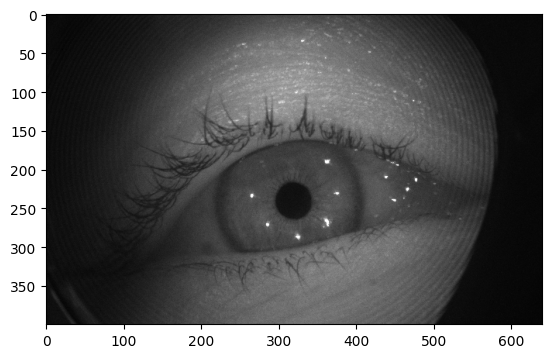

In [134]:
def thresh(elem, root):
    if root.left is None and root.right is None:
        return root.root.mean
    elif elem <= root.root.mean:
        return thresh(elem, root.left)
    else:
        return thresh(elem,root.right)


img_path = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/train/sequences/6623/005.png'
img = plt.imread(img_path)
root = min_var_quant(img, 2)

print('----')
print(img[0][0])
print(thresh(img[0][0], root))

plt.imshow(img, cmap='gray')
thresh_img = np.vectorize(thresh)(img)
# plt.imshow(, cmap='gray')


# print()


In [80]:
# Algorithm:
#   - Compute Sum() projections.
#   - For each projection, compute mean, variance, optimal partition (Otsu), and variances of the two partitions.
#   - Create a "partition" object using the data for the dimension whose partition most reduces the variance.
#   - Build a priority queue for partition objects. Priority = decrease of variance if partition is split.
#   - Handle partition objects in descending priority:
#      - Take the top projection object.
#      - Split along the best dimension.
#      - Re-compute the associated projections.
#      - Add 2 new projection objects to the priority queue.
#   - Each of the partition objects on the queue are leaves of the k-d tree.
#   - Each time we take a partition off the queue, we add a branch node to the k-d tree.

def min_var_quant(img, bits):
    # priority queue of partitions (initially empty)

    # create partition of og image
    # create root node from partition of og image
    # choose best partition out of all possible partitions populate priority queue
    # until we reach # leaf nodes we want, keep popping off & partitioning

    leaves = 2**bits
    root_part = Partition(img)
    root = KDTree(root_part)
    
    


    # while root.count_leaves() != leaves:
    #root_part.find_optimal_split()
    
    
    


    
    # print("root")
    # print(np.shape(root_part.image))
    # print(root_part.mean)
    # print(np.shape(root_part.half0))
    # print(np.shape(root_part.half1))
    
    # half0, half1 = root_part.split()
    # half0.find_optimal_split()
    # half1.find_optimal_split()
    # print("half0")
    # print(np.shape(half0.image))
    # print(half0.mean)
    # print(np.shape(half0.half0))
    # print(np.shape(half0.half1))
    
    # # print(np.shape(root_part.half0))
    # # print(np.shape(root_part.half1))

    # print("half1")
    # print(np.shape(half1.image))
    # print(half1.mean)
    # print(np.shape(half1.half0))
    # print(np.shape(half1.half1))
    # # print(np.shape(root_part.half0))
    # # print(np.shape(root_part.half1))

    # root =  KDTree("hi")
    # l1 = KDTree("l1")
    # l2 = KDTree("l2")
    # l3 = KDTree("l3")
    # l4 = KDTree("l4")
    # l5 = KDTree("l5")
    # l6 = KDTree("l6")
    # l7 = KDTree("l7")
    # l8 = KDTree("l8")
    # root.set_left(l1)
    # root.set_right(l2)
    # l1.set_left(l3)
    # l1.set_right(l4)
    # l3.set_left(l5)
    # l3.set_right(l6)
    # l5.set_left(l7)
    # l5.set_right(l8)



img_path = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/train/sequences/6625/005.png'
img = plt.imread(img_path)
min_var_quant(img, 2)

    


he


In [47]:
quant_scheme = 'kmeans'

for data_type in ['train', 'validation', 'test']:
	datatype_dir = os.path.join(data_dir, data_type, 'sequences')
	for directory in os.listdir(datatype_dir):
		for img_file in os.listdir(os.path.join(datatype_dir, directory)):
			img_path = os.path.join(datatype_dir, directory, img_file)
			img = io.read_image(img_path).to(torch.uint8)[0]

			match quant_scheme:
				case 'uniform':
					img = uniform_quant(img)

				case 'manual':
					img = manual_quant(img)

				case 'peaks':
					img = peak_quant(img)

				case 'kmeans':
					img = kmeans_quant(img)
					
			img = np.where(img == img.max(), 255, img).astype(np.uint8)

			out_temp_dir = os.path.join(out_dir, data_type, 'sequences', directory)
			print(img_file, out_temp_dir)
			if not os.path.isdir(out_temp_dir):
				os.system(f'mkdir -p {out_temp_dir}')
			out_img_path = os.path.join(out_temp_dir, img_file)

			img = Image.fromarray(img)
			img.save(out_img_path)

			# utils.save_image(img, out_img_path)
			# plt.imshow(img.reshape(img.shape[1:]), cmap='gray')
			break
		break
	break


NameError: name 'data_dir' is not defined